## Recruitment task - Analyst

### Task 2

**Forecast of the number of orders in January and February 2020.**

The sales forecast was made with the time series model and the Prophet library was used for analysis.

In [1]:
!pip install fbprophet

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Import and reading data

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot
%matplotlib inline

from fbprophet import Prophet

In [4]:
cd '/content/drive/My Drive/moje pliki'

/content/drive/My Drive/moje pliki


In [121]:
pred = pd.read_csv('predykcja.csv', sep=';')
pred.head()

,DATA,zamowienia,wyprzedaż
0,01.01.2018,100.0,NaN
1,02.01.2018,94.0,NaN
2,03.01.2018,118.0,1.0
3,04.01.2018,114.0,1.0
4,05.01.2018,122.0,1.0


In [122]:
pred.tail()

,DATA,zamowienia,wyprzedaż
1815,NaN,NaN,NaN
1816,NaN,NaN,NaN
1817,NaN,NaN,NaN
1818,NaN,NaN,NaN
1819,NaN,NaN,NaN


In [123]:
pred.shape

(1820, 3)

In [124]:
pred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1820 entries, 0 to 1819
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   DATA        731 non-null    object 
 1   zamowienia  731 non-null    float64
 2   wyprzedaż   73 non-null     float64
dtypes: float64(2), object(1)
memory usage: 42.8+ KB


### Cleaning data

We delete missing data:

In [125]:
pred.dropna(subset=['DATA'], inplace=True)

In [126]:
pred.isnull().sum()

DATA            0
zamowienia      0
wyprzedaż     658
dtype: int64

In [127]:
pred['DATA'] = pd.to_datetime(pred['DATA'], errors='coerce')

#fill column with 0 where NaN
pred['wyprzedaż'] = pred['wyprzedaż'].fillna('0')

In [128]:
pred.head()

,DATA,zamowienia,wyprzedaż
0,2018-01-01,100.0,0
1,2018-02-01,94.0,0
2,2018-03-01,118.0,1
3,2018-04-01,114.0,1
4,2018-05-01,122.0,1


We select only two columns for analysis: "Data" and "zamówienia":

In [130]:
df = pred[['DATA', 'zamowienia']]
df.head()

,DATA,zamowienia
0,2018-01-01,100.0
1,2018-02-01,94.0
2,2018-03-01,118.0
3,2018-04-01,114.0
4,2018-05-01,122.0


Daily order chart:

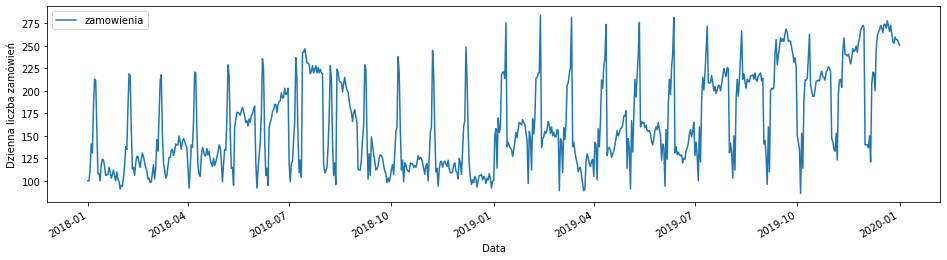

In [131]:
ax = df.set_index('DATA').plot(figsize = (16, 4))
ax.set_ylabel('Dzienna liczba zamówień')
ax.set_xlabel('Data')
plt.show()

In [132]:
# from the prophet documentation every variables should have specific names
df2 = df.rename(columns = {'DATA': 'ds', 'zamowienia': 'y'})
df2.head()

,ds,y
0,2018-01-01,100.0
1,2018-02-01,94.0
2,2018-03-01,118.0
3,2018-04-01,114.0
4,2018-05-01,122.0


### Time series model

We forecast for 2 months, i.e. the next 60 days:

In [133]:
#create model
model = Prophet()
model.fit(df2)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [134]:
#dataframe that extends into future 60 days
future = model.make_future_dataframe(periods=60)
future.tail()

,ds
786,2020-02-26
787,2020-02-27
788,2020-02-28
789,2020-02-29
790,2020-03-01


The **predict** method is used to predict. A forecast is a new data frame that contains the date; the forecast value; the lower and upper forecast values, that means uncertainty ranges.

**yhat** is the forecast value.

In [135]:
#predictions
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
786,2020-02-26,293.354795,243.184008,340.548220
787,2020-02-27,292.191359,241.512858,334.653685
788,2020-02-28,290.933401,241.183945,338.267352
789,2020-02-29,292.166487,244.375682,341.502753
790,2020-03-01,289.494617,243.439664,338.009250


**Prediction visualization**

Prophet plots the observed values of our time series (black dots), the predicted values (blue line), and the uncertainty ranges of our forecasts (areas shaded in blue).

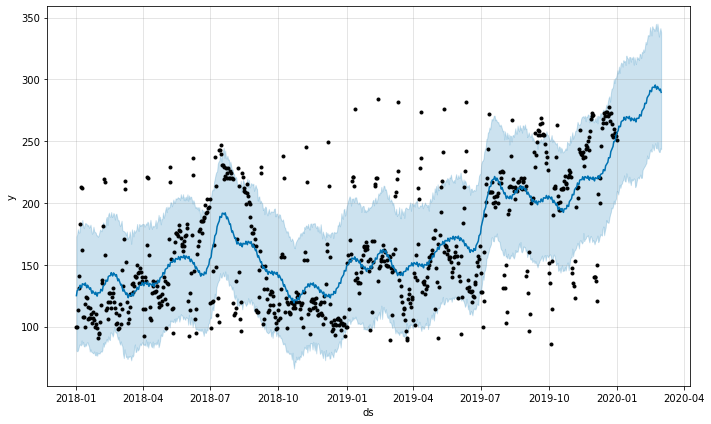

In [136]:
model.plot(forecast);

**Forecast components**

This can help reveal how the daily, weekly, and yearly time series patterns and the number of holidays included affect the overall projected values.

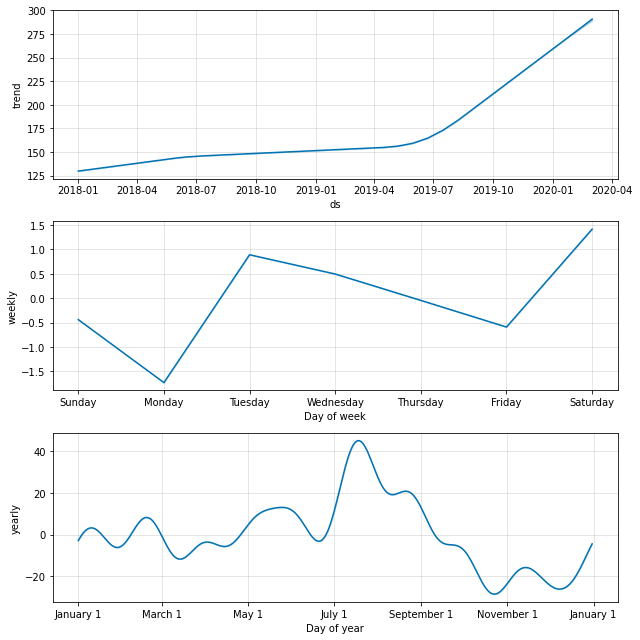

In [137]:
model.plot_components(forecast);

The first graph shows the monthly orders increasing over time, the second graph shows that the peak orders for the week are on Saturday, and the last graph shows the busiest season which is the holiday season (July and August).

**Estimated number of orders for January and February without sale**

In [138]:
orders = forecast[['ds', 'yhat']].tail(60)
orders.head()

,ds,yhat
731,2020-01-02,257.507073
732,2020-01-03,258.618611
733,2020-01-04,262.184932
734,2020-01-05,261.772154
735,2020-01-06,261.797957


In [139]:
orders2 = orders.head(59)
orders2.tail()

,ds,yhat
785,2020-02-25,294.261802
786,2020-02-26,293.354795
787,2020-02-27,292.191359
788,2020-02-28,290.933401
789,2020-02-29,292.166487


In [140]:
orders2['yhat'].mean()

276.1155969899597

In [141]:
orders2['yhat'].sum()

16290.820222407623

The estimated number of orders for January and February without sale is 16 291.
The daily average number of orders is 276.

### Model with sale

In [142]:
sale = pred[['DATA', 'wyprzedaż']]
sale.head()

,DATA,wyprzedaż
0,2018-01-01,0
1,2018-02-01,0
2,2018-03-01,1
3,2018-04-01,1
4,2018-05-01,1


Prophet also allows to model for holidays. We will use this model for forecasting orders with include sale. 

The sale variable in the dataset includes a sale:

In [143]:
# create holidays dataframe
sale_data = sale[sale['wyprzedaż'] == 1].loc[:, 'DATA'].values
holidays = pd.DataFrame({'ds': pd.to_datetime(sale_data),
                          'holiday': 'wyprzedaż'})

In [144]:
holidays.head()

,ds,holiday
0,2018-03-01,wyprzedaż
1,2018-04-01,wyprzedaż
2,2018-05-01,wyprzedaż
3,2018-06-01,wyprzedaż
4,2018-07-01,wyprzedaż


In [145]:
#create model include sale
model2 = Prophet(holidays = holidays)
model2.fit(df2)

future_dates = model2.make_future_dataframe(periods=60)
predictions = model2.predict(future_dates)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [146]:
#predictions
predictions[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
786,2020-02-26,292.714266,249.008606,342.323919
787,2020-02-27,292.298085,241.205640,336.755727
788,2020-02-28,291.094368,241.050519,336.842776
789,2020-02-29,292.396097,246.689683,344.138289
790,2020-03-01,289.803965,243.908582,338.787079


**Prediction visualization**

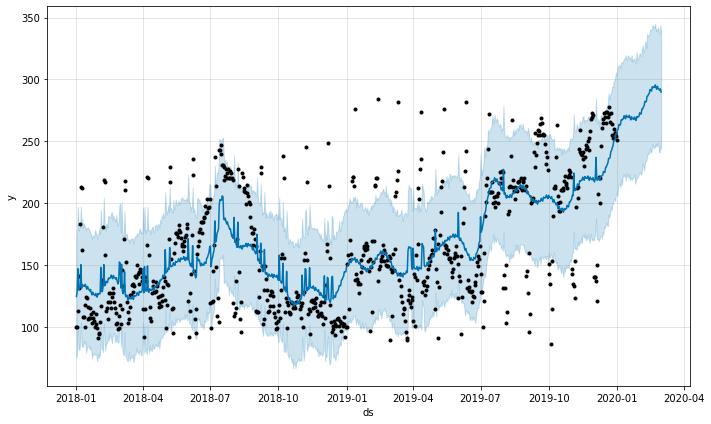

In [147]:
model2.plot(predictions);

**Forecast components**

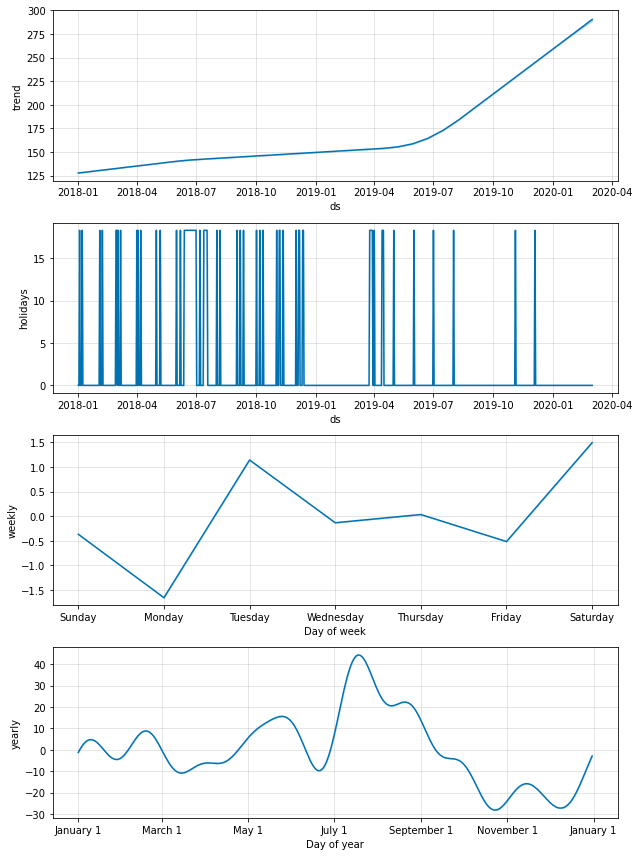

In [148]:
model2.plot_components(predictions);

**Estimated number of orders for January and February with sale**

In [149]:
order = predictions[['ds', 'yhat']].tail(60)
order.head()

,ds,yhat
731,2020-01-02,258.912959
732,2020-01-03,260.079909
733,2020-01-04,263.680396
734,2020-01-05,263.281095
735,2020-01-06,263.307409


In [150]:
order_sale = order.head(59)
order_sale.tail()

,ds,yhat
785,2020-02-25,294.479163
786,2020-02-26,292.714266
787,2020-02-27,292.298085
788,2020-02-28,291.094368
789,2020-02-29,292.396097


In [151]:
order_sale['yhat'].mean()

277.08567183787176

In [152]:
order_sale['yhat'].sum()

16348.054638434438

The estimated number of orders for January and February with sale is 16 348.
The daily average number of orders is 277.